# Performace corporal

O presente notebook pretende fazer algumas análises sobre a aptidão física das pessoas. O dataset utilizado é o do bodyPerformance baixado do Kaggle


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import io
import seaborn as sns
from random import randint

In [2]:
from google.colab import files

## Faça upload de um dataset com nome bodyPerformance (baixável em https://www.kaggle.com/kukuroo3/body-performance-data)
uploaded = files.upload()

Saving bodyPerformance.csv to bodyPerformance.csv


In [72]:
dep = pd.read_csv('/content/bodyPerformance.csv')
dep.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [4]:
dep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [5]:
R, C = dep.shape  #linhas e colunas do dataframe

Conversão das classes para parâmetros numéricos (importante para avaliar correlação)

In [73]:

for i in range(R):
  if (dep.at[i,"class"] == 'A'):
    dep.at[i,"Class"] = 4
  elif (dep.at[i,"class"]  == 'B'):
    dep.at[i,"Class"]  = 3
  elif (dep.at[i,"class"]  == 'C'):
    dep.at[i,"Class"]  = 2
  elif (dep.at[i,"class"] == 'D'): dep.at[i,"Class"]  = 1

  #pd.to_numeric(dep.at[i,"class"], errors = 'coerce')
dep = dep.drop(['class'],axis = 1)


In [7]:
dep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  Class                    13393 non-null  float64
dtypes: float64(11), object(1)
memory usage: 1.2+ MB


In [8]:
dep.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627,2.499813
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000,1.118109
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000,1.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000,1.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000,2.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000,3.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000,4.000000


# 1. Data cleaning

Olhando a tabela que surge através do método describe, vemos alguns pontos que são um pouco fora dor normal. As idades, alturas (se bem que 125 cm é bem baixo, mas com mais de 13'000 pessoas de amotras talvez faça sentido). Pode-se também entender como valores zerados de gripForce, sit_ups e broad jump_cm existem, pois as pessoas podem não ter conseguidos fazer os movimento devido a alguma impossibilidade mecânica. Logo a eliminação completa nao seria interessante.  No entante, claramente a pressão sanguínea diastólica e sistólica não podem ser 0, pois senão a pessoa estaria morta. O sit and bend forward, embora tenha um mínimo negativo, na verdade faz sentido. No entanto, seu valor máximo de 213 cm não faz sentido, pois é maior que a pessoa mais alta, de 193 cm. Abaixo também é discutido o problema de body fat.

O valor de body fat máximo (e sinceramente, o mínimo de 3%, um cara a esse nível ta morto já), parecem bem irrazoáveis. Eu particularmente não esperaria menos de 150kg para um homem com 78% de gordura, mas o dataset nos dá 74,5 (o que nao faz sentido). Segue que há alguns valores sem muito sentido

In [9]:
dep[dep["body fat_%"]==dep["body fat_%"].max()]

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
735,21.0,M,177.6,74.5,78.4,69.0,122.0,44.9,26.1,59.0,235.0,4.0


In [10]:
dep[dep["body fat_%"] == dep["body fat_%"].min()]

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
460,24.0,M,170.6,69.9,3.0,75.0,123.0,52.40,23.9,60.0,280.0,4.0
939,28.0,M,178.3,76.8,3.0,73.0,145.0,53.66,29.5,68.0,259.0,4.0


Dado o fato que esses extremos de percentual de gordura simplesmente não são compatíveis com a realidade, o mais coerente seria eliminá-los por completo. Abaixo são eliminados valores muito extremos de gordura, pressão arterial e sit and bend forward

In [74]:
aux = dep.copy()
aux.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2.0
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,4.0
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2.0
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,3.0
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,3.0


In [75]:

trues = (dep["body fat_%"] < 6) | (dep["body fat_%"]>49) | (dep["diastolic"] < 40) | (dep["systolic"] < 60) | (dep["sit and bend forward_cm"] > 80)

print(trues.sum(), "\n")
indeces = np.where(trues)

a,b = np.shape(indeces)
drops = np.reshape(indeces,b)
aux.drop(drops)



37 



,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2.0
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,4.0
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2.0
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,3.0
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,M,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,2.0
13389,21.0,M,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,1.0
13390,39.0,M,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,4.0
13391,64.0,F,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,1.0


No final eliminamos somente 37 entradas, que provavelmente eram simplesmente defeituosas

#2 Correlações

Para saber qual fator mais influencia com a classe, é preciso fazer a correlação. Nesse caso, correlação de fato implica em causa, pois o que faz determinada classificação ser feita é justamente esses fatores. Vemos que  fator que mais influencia a escolha da classe é o sit and bend forward (ou seja, uma medida de flexibilidade). Depois disso a quantidade de abdominais. Também esperado, o body fat tem uma correlação negativa grande, pois quanto mais gordura a pessoa possuir, menor tenderá a ser sua performance corpórea

In [76]:
aux.corr()
#for columns in range(C):


,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
age,1.000000,-0.293980,-0.099966,0.242302,0.158508,0.211167,-0.179583,-0.070033,-0.544581,-0.435172,-0.065612
height_cm,-0.293980,1.000000,0.734909,-0.515440,0.145933,0.210186,0.735024,-0.221970,0.500424,0.674589,-0.037753
weight_kg,-0.099966,0.734909,1.000000,-0.084065,0.262317,0.338943,0.700119,-0.296249,0.294899,0.479564,-0.214129
body fat_%,0.242302,-0.515440,-0.084065,1.000000,0.048059,-0.030376,-0.541788,-0.071225,-0.608912,-0.673273,-0.341956
diastolic,0.158508,0.145933,0.262317,0.048059,1.000000,0.676309,0.202062,-0.072098,0.016547,0.097243,-0.066761
systolic,0.211167,0.210186,0.338943,-0.030376,0.676309,1.000000,0.286012,-0.082434,0.056276,0.152894,-0.035484
gripForce,-0.179583,0.735024,0.700119,-0.541788,0.202062,0.286012,1.000000,-0.112577,0.576669,0.746853,0.136088
sit and bend forward_cm,-0.070033,-0.221970,-0.296249,-0.071225,-0.072098,-0.082434,-0.112577,1.000000,0.177153,0.026487,0.588123
sit-ups counts,-0.544581,0.500424,0.294899,-0.608912,0.016547,0.056276,0.576669,0.177153,1.000000,0.748273,0.452832
broad jump_cm,-0.435172,0.674589,0.479564,-0.673273,0.097243,0.152894,0.746853,0.026487,0.748273,1.000000,0.262154


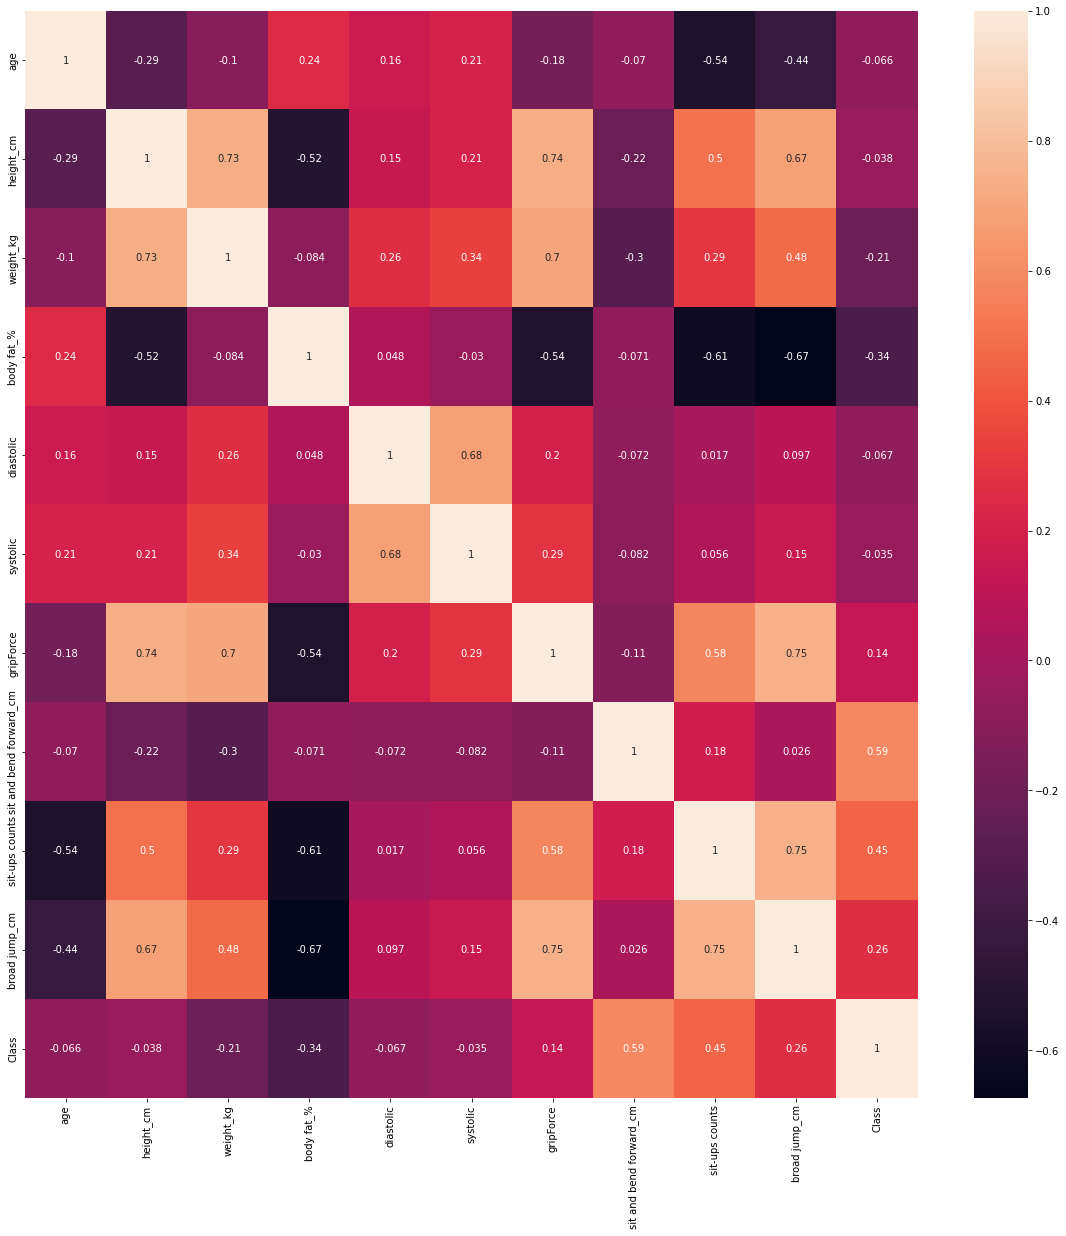

In [77]:
plt.figure(figsize = (20,20))

sns.heatmap(aux.corr(), annot = True)

Interessantemete, o fator que parece mais se correlacionar com a classe é o sit and bend forward (uma medida de flexibilidade), seguido pelo sit up count (uma medida de força). Interessantemente, a maior correlação de forma geral está entre altura e gripForce, com 0,74 de correlação. Isso faz sentido, pois homens tendem a ser mais altos e mais fortes.

Vamos avaliar agora os histogramas de cada feature


In [78]:
aux.columns

Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'Class'],
      dtype='object')

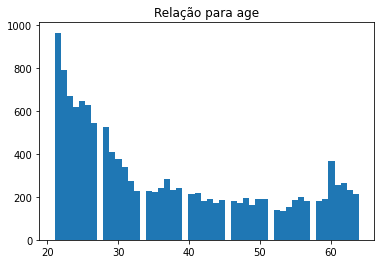

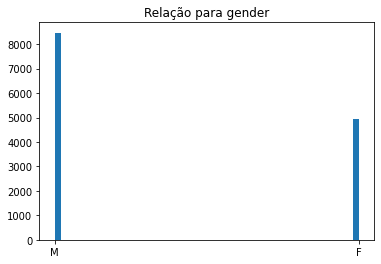

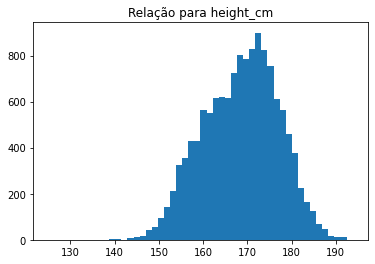

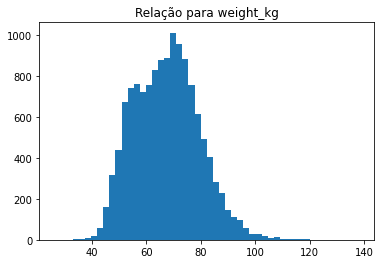

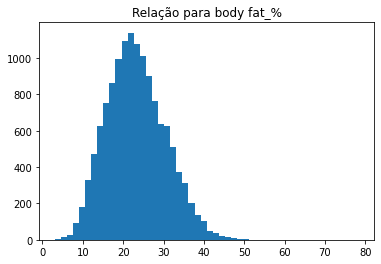

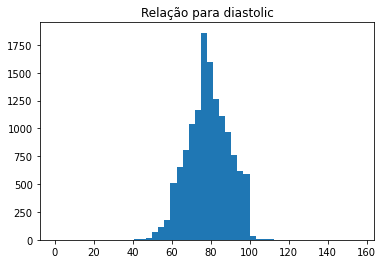

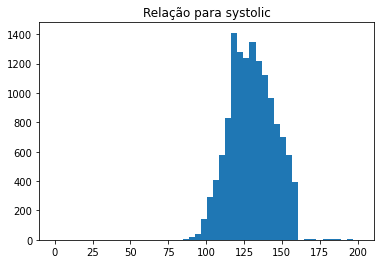

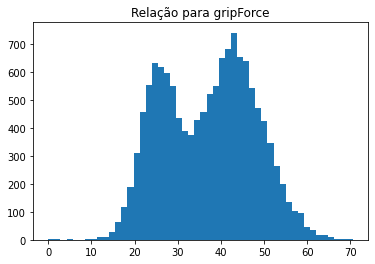

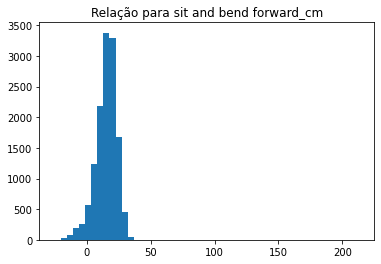

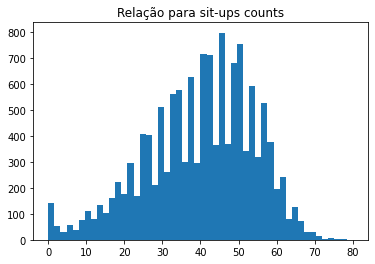

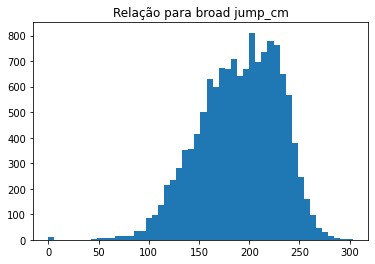

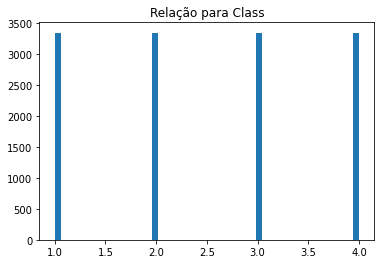

In [79]:
for name in aux.columns:
  plt.hist(aux[name],bins = 50)
  plt.title("Relação para " + name)
  plt.show()

Observe que, como esperado, a maioria das distribuições segue a forma de sino conhecida da distribuição Gaussiana, com exceção notável dos casos de classificação (Class e gender), assim como idade (originalmente pensei que fosse semelhante a uma pirâmide etária, onde há mais jovens do que velhos, mas a Coreia já é um país um pouco mais velho, então suponho que houve um viés de seleção para pessoas mais novas).

#3 Diferenças entre homens e mulheres

Na análise anterior, podemos ver no histograma de grip force que há dois picos. Isso me faz pensar que esses picos tenham a ver com a diferença de força entre homens e mulheres. Vamos analisar aqui algumas diferenças entre os dois sexos

In [80]:
depMale = aux[aux["gender"] == 'M']
depFemale = aux[aux["gender"] == 'F']


In [81]:
depMale.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
count,8467.000000,8467.000000,8467.000000,8467.000000,8467.000000,8467.000000,8467.000000,8467.000000,8467.000000,8467.000000,8467.000000
mean,36.149167,173.257399,73.580187,20.188151,80.669411,133.870072,43.448420,13.097073,44.939176,211.541526,2.435337
std,13.103067,5.810007,9.468653,5.952703,10.350981,13.563141,7.170091,8.441618,11.729377,28.267162,1.098576
min,21.000000,145.800000,36.500000,3.000000,6.000000,14.000000,0.000000,-25.000000,0.000000,0.000000,1.000000
25%,25.000000,169.300000,67.300000,16.000000,74.000000,123.000000,38.800000,8.800000,37.000000,194.000000,1.000000
50%,32.000000,173.100000,72.800000,20.000000,81.000000,134.000000,43.300000,14.200000,46.000000,214.000000,2.000000
75%,45.000000,177.100000,79.000000,24.000000,88.000000,144.000000,48.100000,18.300000,54.000000,231.000000,3.000000
max,64.000000,193.800000,138.100000,78.400000,126.000000,201.000000,70.500000,213.000000,80.000000,303.000000,4.000000


In [82]:
depFemale.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
count,4926.000000,4926.000000,4926.000000,4926.000000,4926.000000,4926.000000,4926.000000,4926.000000,4926.000000,4926.000000,4926.000000
mean,37.850995,160.485404,56.905899,28.486085,75.578197,123.986399,25.817994,18.839791,30.888348,153.326025,2.610637
std,14.417859,5.648771,7.639541,6.224667,10.639717,14.515961,4.695002,7.149408,13.888988,28.381922,1.142551
min,21.000000,125.000000,26.300000,3.500000,0.000000,0.000000,0.000000,-22.000000,0.000000,0.000000,1.000000
25%,24.000000,156.600000,51.965000,24.100000,68.000000,114.000000,22.700000,15.300000,21.000000,135.000000,2.000000
50%,34.000000,160.500000,55.900000,28.300000,75.000000,123.000000,25.600000,20.000000,32.000000,156.000000,3.000000
75%,51.000000,164.300000,61.000000,32.600000,83.000000,133.000000,28.800000,23.500000,41.000000,173.000000,4.000000
max,64.000000,179.000000,113.300000,53.500000,156.200000,184.000000,45.500000,35.200000,74.000000,260.000000,4.000000


Temos quase o dobro de homens que mulheres, mas ainda assim, a amostra de quase 5000 pessoas para mulheres é representativa o suficiente. Acima vemos algumas características esperadas, como homens sendo em média mais altos e fortes que mulheres, enquanto mulheres são mais flexíveis e têm um percentual de gordura um pouco mais alto. Algo interessante de se avaliar seria qual a diferença percentual entre as médias dos sexos

In [96]:
notObject = aux.columns[aux.dtypes!='object']
percent = []
for name in notObject:
  percent.append(depFemale[name].mean()/depMale[name].mean())

depPercent = pd.DataFrame(percent, index = notObject)
depPercent


,0
age,1.047078
height_cm,0.926283
weight_kg,0.773386
body fat_%,1.411030
diastolic,0.936888
systolic,0.926170
gripForce,0.594222
sit and bend forward_cm,1.438473
sit-ups counts,0.687337
broad jump_cm,0.724803


Vemos acima a relação percentual média entre homens e mulheres. Quando os valores são menores do que 1, temos que homens tendem a ter maiores resultados, enquanto no caso de serem maiores do que 1, mukheres tendem a ter maiores resultado. Vemos que homens são notadamente melhores em gripForce e em sit-ups counts, enquanto mulheres tendem a ter maior percentual de gordura. Mulheres também tendem a ter uma classificação (Class) acima da masculina. Isso nos leva a pensar que os parâmetros aos quais homens e mulheres são submetidos para sua classificação é diferente. É importante notar isso, pois na sequência desse trabalho deseja-se fazer um sistema de classificação dos dados que foram mal anotados.

#4 Normalização e dimensionamento

Vamos dimensionar o dataset para melhor manipulação. Abaixo temos minha função criada para minmax scaling, enquanto logo abaixo temos o código nativo já criado

In [43]:
def scales(df):
  df.columns
  notObject = df.columns[df.dtypes!='object']
  #df[notObject]
  for name in notObject:
    df[name] = (df[name]-df[name].min())/(df[name].max()-df[name].min())
  return df

dep_norm = scales(dep)

dep_norm.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
0,0.139535,M,0.687500,0.437746,0.242706,0.512164,0.646766,0.778723,0.182353,0.7500,0.716172,0.333333
1,0.093023,M,0.581395,0.263864,0.168435,0.492958,0.626866,0.516312,0.173529,0.6625,0.755776,1.000000
2,0.232558,M,0.793605,0.462433,0.226790,0.588988,0.756219,0.635461,0.155462,0.6125,0.597360,0.333333
3,0.255814,M,0.719477,0.400716,0.204244,0.486556,0.731343,0.587234,0.168908,0.6625,0.722772,0.666667
4,0.162791,M,0.709302,0.370304,0.187003,0.448143,0.631841,0.617021,0.218908,0.5625,0.716172,0.666667


In [40]:
from sklearn.preprocessing import minmax_scale
notObject = dep.columns[dep.dtypes!='object']
depScaled = minmax_scale(dep[notObject], feature_range=(0,1))

depS = pd.DataFrame(data = depScaled, columns = notObject)

depS.head()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
0,0.139535,0.687500,0.437746,0.242706,0.512164,0.646766,0.778723,0.182353,0.7500,0.716172,0.333333
1,0.093023,0.581395,0.263864,0.168435,0.492958,0.626866,0.516312,0.173529,0.6625,0.755776,1.000000
2,0.232558,0.793605,0.462433,0.226790,0.588988,0.756219,0.635461,0.155462,0.6125,0.597360,0.333333
3,0.255814,0.719477,0.400716,0.204244,0.486556,0.731343,0.587234,0.168908,0.6625,0.722772,0.666667
4,0.162791,0.709302,0.370304,0.187003,0.448143,0.631841,0.617021,0.218908,0.5625,0.716172,0.666667


O resultado da função que criei e a importada de sklearn são os mesmos. Finalmente, utilizamos o método boxcox para normalizar o dataset

In [62]:
from scipy import stats
notObject = dep.columns[dep.dtypes!='object']

try:
  for name in notObject:
    data = abs(dep[name])
    normcolumn = stats.boxcox(data)
    dfColumnsTensor = dfColumnsTensor.append(normcolumn)
except ValueError:
  print("Um erro de valor (ValueError) ocorreu")


Um erro de valor (ValueError) ocorreu


A boxcox só recebe valores positivos, e como muitas das colunas têm valores negativos e/ou neutros, talvez não faça sentido

#5 (A fazer) - Previsão de classe para elementos dropados